In [1]:
# LSTM plot is a work in progress

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
tf.random.set_seed(42)

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.base import prediction

import itertools as it
import time
from tqdm import tqdm_notebook
from ipywidgets import interact, Dropdown
# !pip install voila

In [3]:
power_train = pd.read_csv('./datasets/power_train.csv', index_col=0)
power_train.index = pd.DatetimeIndex(power_train.index, freq='H')

power_val_data = pd.read_csv('./datasets/power_val_data.csv', index_col=0)
power_val_data.index = pd.DatetimeIndex(power_val_data.index)

power_val_target = pd.read_csv('./datasets/power_val_target.csv', index_col=0)
power_val_target.index = pd.DatetimeIndex(power_val_target.index)

power_val_benchmark = pd.read_csv('./datasets/power_val_benchmark.csv', index_col=0)
power_val_benchmark.index = pd.DatetimeIndex(power_val_benchmark.index)

# restrict analysis to wind farm 1

wp1_train = power_train['wp1']
wp1_val_data = power_val_data['wp1']
wp1_val_target = power_val_target['wp1']
wp1_val_benchmark = power_val_benchmark['wp1']

wp1_predictions_sarimax = pd.read_csv('./datasets/wp1_predictions_sarimax.csv', index_col=0)
wp1_predictions_sarimax.index = pd.DatetimeIndex(wp1_predictions_sarimax.index)

In [4]:
# define function to set up data in correct format for LSTM
def format_training_data(timeseries, n_lags, len_target_seq):
    
    '''formats timeseries into LSTM input format'''
    
    if not isinstance(timeseries, pd.Series):
        timeseries = pd.Series(timeseries.ravel()) # flattens list of lists to one list
    
    n_shifts = n_lags + len_target_seq
    lags = pd.DataFrame({'t'+str(i): timeseries.shift(-i) for i in range(0,n_shifts)})
    lags = lags.dropna()
    
    features = lags.iloc[:,:n_lags]
    target = lags.iloc[:, n_lags:]
    
    features_arr = features.values
    features_arr = np.reshape(features_arr, (features_arr.shape[0], features_arr.shape[1], 1))
    target_arr = target.values
    
    return features_arr, target_arr

In [5]:
def forecast_next_48hrs(model, data):
    
    '''forecasts next 48 hours'''
    output_size = model.get_config()['layers'][1]['config']['units']
    for n in range(48//output_size):
        batch_size, num_lags, num_features = model.get_config()['layers'][0]['config']['batch_input_shape']
        lag_data = np.reshape(data[-num_lags:].values, (batch_size, num_lags, num_features))
        pred = model.predict(lag_data, batch_size=batch_size)[0]
        for i in range(len(pred)):
            if len(pred) <= 1:
                data = data.append(pd.Series(pred, index = [data.index[-1]+pd.Timedelta(hours=1)]))
            else:
                data = data.append(pd.Series(pred))

    return data[-48:]

In [6]:
def make_forecasts(model, data_series):
        
    '''forecasts sets of 48 hours of power output in repeated 36 hour windows'''
    
    predictions = pd.Series()
    num_patterns = int(data_series.shape[0]/36) # 36 hours of data, followed by 48 hour gaps
    
    for pattern_num in range(num_patterns):
        data = data_series[36*pattern_num:36*(pattern_num+1)]
        forecast = forecast_next_48hrs(model, data)
        predictions = predictions.append(forecast)
    
  # ARIMA model index:
  # ix = pd.date_range(start=data_series.index[0], end=data_series.index[-1]+pd.Timedelta(hours=48), freq='H')
  # forecast_ix = [date for date in ix if date not in data_series.index]
    
    return predictions

In [7]:
def build_model(training_data, n_lags, n_outputs, n_nodes, stateful = False, epochs=1, verbose=0):
    
    # Formatting input data
    features, target = format_training_data(training_data, n_lags = n_lags, len_target_seq = n_outputs)
    
    # Initializing the model
    batch_size = 1
    model = Sequential()
    model.add(LSTM(n_nodes,
                  batch_input_shape = (batch_size, features.shape[1], features.shape[2]),
                  stateful = stateful))
    model.add(Dense(n_outputs)) # no activation function included
    
    if verbose == 1:
        model.summary()
    
    # Compiling and and fitting the model
    model.compile(loss='mean_squared_error', optimizer='adam')
    if stateful:
        for i in range(epochs): # loop over epochs manually
            history = model.fit(features, target, validation_data = None,
                 epochs = 1, batch_size = batch_size, verbose=verbose, shuffle=False)
            model.reset_states()
    else:
        history = model.fit(features, target, validation_data = None,
             epochs = epochs, batch_size = batch_size, verbose=verbose, shuffle=False)
        
    return model, history

In [8]:
settings_dict= {'n_lags': [2,36],
                'n_outputs': [1,48],
                'stateful': [True, False]}

settings_combs = list(it.product(*settings_dict.values()))

settings = pd.DataFrame(settings_combs, columns=settings_dict.keys())

In [9]:
# Creating lists to keep track of each model's RMSE and run time.
RMSE = []
run_time = []


#TQDM creates a progress bar to give range of run time for each LSTM
for idx in tqdm_notebook(settings.index, desc='Progress', leave=True):
    
    # Random seed for reproducibility
    np.random.seed(42)
    
    t0 = time.time()
    
    # Implementing LSTM function with dict parameters on first wind farm
    model, history = build_model(wp1_train,
                               n_lags = settings.loc[idx,'n_lags'],
                               n_outputs = settings.loc[idx,'n_outputs'], 
                               n_nodes = 2, 
                               stateful = settings.loc[idx,'stateful'], 
                               epochs = 3, 
                               verbose=0)
    t1 = time.time()
    
    # Implementing forecast function
    model_predictions = make_forecasts(model, wp1_val_data)
    
    # Calculating RMSE
    model_RMSE = mean_squared_error(y_true = wp1_val_target, y_pred = model_predictions)**0.5
    
    RMSE.append(model_RMSE)
    run_time.append(t1-t0)

# Including RMSE and run-time in the model performance dataframe.
model_perf = pd.concat([settings, pd.DataFrame(RMSE, columns=['RMSE'])], axis=1)
model_perf = pd.concat([model_perf, pd.DataFrame(run_time, columns=['run_time'])], axis=1)

<ipython-input-9-85d533f638f3>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx in tqdm_notebook(settings.index, desc='Progress', leave=True):


Progress:   0%|          | 0/8 [00:00<?, ?it/s]

<ipython-input-6-ec3528cbfee7>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series()
<ipython-input-6-ec3528cbfee7>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series()
<ipython-input-6-ec3528cbfee7>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series()
<ipython-input-6-ec3528cbfee7>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series()
<ipython-input-6-ec3528cbfee7>:5: DeprecationWarning: The default dtype for empty Series

In [10]:
setting_select = Dropdown(
options = list(model_perf.columns[0:3]),
value = model_perf.columns[0],
description = 'Compare:',
)

def plot_widget(setting = model_perf.columns[0]):
    
    sns.lmplot(x='RMSE',y='run_time', data = model_perf, hue = setting, fit_reg=False, 
               size=5, aspect=2,  scatter_kws={"s": 500}, palette = 'Set1');
    
    sort_cols = list(model_perf.columns[0:3])
    sort_cols.remove(setting)
    
    model_perf.sort_values(by=sort_cols, inplace=True)
    for n in range(model_perf.shape[0]//2):
        row_pair = model_perf.iloc[n*2:n*2+2,-2:].values
        plt.plot(row_pair[:,0], row_pair[:,1], '--', color='k')
    
    ax = plt.gca()    
    
    ax.set_xlim(0.2,0.5)
    ax.set_ylim(0, 1000)
    
    ax.set_xlabel('RMSE', fontsize=14)
    ax.set_ylabel('run time', fontsize=14)
    ax.set_title('How model performance varies with {} setting\n'.format(setting), fontsize=18);
    
        
interact(plot_widget, setting = setting_select);

interactive(children=(Dropdown(description='Compare:', options=('n_lags', 'n_outputs', 'stateful'), value='n_l…

In [11]:
RMSE_by_node_dict = {}

for n in tqdm_notebook(range(1,11), desc='Progress', leave=True):
    
    np.random.seed(42)
    
    model, history = build_model(wp1_train, n_lags = 2, n_outputs = 48, n_nodes = n, stateful = False, epochs = 3, verbose=0)
    
    model_predictions = make_forecasts(model, wp1_val_data)
    model_RMSE = mean_squared_error(y_true = wp1_val_target, y_pred = model_predictions)**0.5
    
    RMSE_by_node_dict[n] = model_RMSE
    
RMSE_by_node = pd.DataFrame(list(RMSE_by_node_dict.items()), columns=['num_nodes','RMSE'])
RMSE_by_node.set_index('num_nodes', inplace=True)

<ipython-input-11-696d4b744843>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm_notebook(range(1,11), desc='Progress', leave=True):


Progress:   0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-6-ec3528cbfee7>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series()
<ipython-input-6-ec3528cbfee7>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series()
<ipython-input-6-ec3528cbfee7>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series()
<ipython-input-6-ec3528cbfee7>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series()
<ipython-input-6-ec3528cbfee7>:5: DeprecationWarning: The default dtype for empty Series

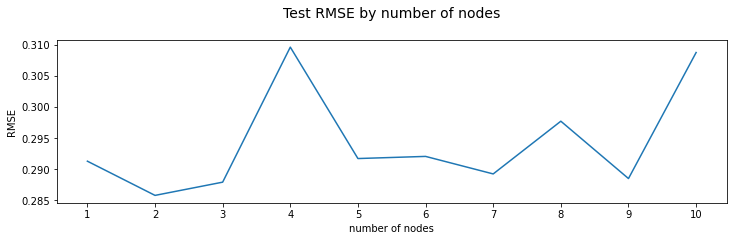

In [12]:
fig, ax = plt.subplots(figsize=(12,3))
plt.plot(RMSE_by_node.index,RMSE_by_node.values, )
ax.set_ylabel('RMSE', fontsize=10)
ax.set_xlabel('number of nodes', fontsize=10)
ax.set_xticks(RMSE_by_node.index)
ax.set_title('Test RMSE by number of nodes\n', fontsize=14);

In [13]:
min_pos = np.argmin(RMSE_by_node.values)
print('Optimal number of nodes: '+str(RMSE_by_node.index[min_pos]))
print('RMSE: '+str(RMSE_by_node.values[min_pos]))

Optimal number of nodes: 2
RMSE: [0.28574031]


In [14]:
training_data = wp1_train
test_data = wp1_val_data
target_data = wp1_val_target
n_lags = 2
n_outputs = 48
n_nodes = 1

np.random.seed(42)

# format data
features, target = format_training_data(training_data, n_lags = n_lags, len_target_seq = n_outputs)
    
# set up model
batch_size = 1
model = Sequential()
model.add(LSTM(n_nodes,
              batch_input_shape = (batch_size, features.shape[1], features.shape[2]),
              stateful = False))
model.add(Dense(n_outputs)) # output layer, no activation function for regression problem
    
# compile and fit model
model.compile(loss='mean_squared_error', optimizer='adam')
    
RMSE_by_epoch_dict = {}

for n in tqdm_notebook(range(1,11), desc='Progress', leave=True):
    
    model.fit(features, target, validation_data = None,
             epochs = 1, batch_size = batch_size, verbose=0, shuffle=False)
        
    # test model
    LSTM_predictions = make_forecasts(model, test_data)
    LSTM_RMSE = mean_squared_error(y_true = target_data, y_pred = LSTM_predictions)**0.5

    RMSE_by_epoch_dict[n] = LSTM_RMSE
    
RMSE_by_epoch = pd.DataFrame(list(RMSE_by_epoch_dict.items()), columns=['num_epochs','RMSE'])
RMSE_by_epoch.set_index('num_epochs', inplace=True)

<ipython-input-14-451c7a781a14>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm_notebook(range(1,11), desc='Progress', leave=True):


Progress:   0%|          | 0/10 [00:00<?, ?it/s]

<ipython-input-6-ec3528cbfee7>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series()
<ipython-input-6-ec3528cbfee7>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series()
<ipython-input-6-ec3528cbfee7>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series()
<ipython-input-6-ec3528cbfee7>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series()
<ipython-input-6-ec3528cbfee7>:5: DeprecationWarning: The default dtype for empty Series

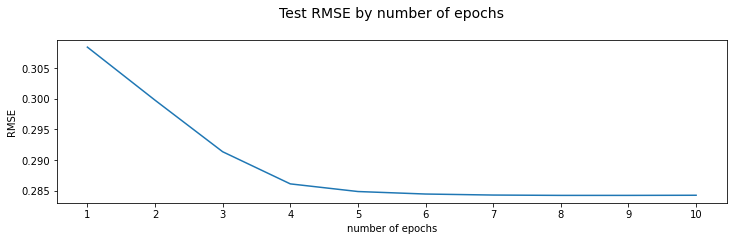

In [15]:
fig, ax = plt.subplots(figsize=(12,3))
plt.plot(RMSE_by_epoch.index,RMSE_by_epoch.values, )
ax.set_ylabel('RMSE', fontsize=10)
ax.set_xlabel('number of epochs', fontsize=10)
ax.set_xticks(RMSE_by_epoch.index)
ax.set_title('Test RMSE by number of epochs\n', fontsize=14);

In [16]:
min_pos = np.argmin(RMSE_by_epoch.values)
print('Optimal number of epochs: '+str(RMSE_by_epoch.index[min_pos]))
print('RMSE: '+str(RMSE_by_epoch.values[min_pos]))

Optimal number of epochs: 9
RMSE: [0.2842184]


In [17]:
np.random.seed(42)

# best settings
n_lags = 2
n_outputs = 48
n_nodes = 2
stateful = False
epochs = 9

model, history = build_model(wp1_train, n_lags, n_outputs, n_nodes, stateful, epochs, verbose=1);

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (1, 2)                    32        
_________________________________________________________________
dense_19 (Dense)             (1, 48)                   144       
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________
Epoch 1/9
10404/10404 [==============================] - 14s 1ms/step - loss: 0.0417
Epoch 2/9
10404/10404 [==============================] - 14s 1ms/step - loss: 0.0413
Epoch 3/9
10404/10404 [==============================] - 15s 1ms/step - loss: 0.0412
Epoch 4/9
10404/10404 [==============================] - 15s 1ms/step - loss: 0.0410
Epoch 5/9
10404/10404 [==============================] - 15s 1ms/step - loss: 0.0410
Epoch 6/9
10404/10404 [==============================] - 14s 1ms/step - loss: 0.0410
Epoch 7

In [18]:
# as the model predicts 48 hours of forecasts in one step, it is valid to compare train and test scores
lstm_predictions = make_forecasts(model, wp1_val_data)
lstm_predictions.to_csv('./datasets/wp1_predictions_lstm.csv')
model_RMSE = mean_squared_error(y_true = wp1_val_target, y_pred = model_predictions)**0.5
print('Train RMSE: ', history.history['loss'][-1]**0.5)
print('Test RMSE: ', model_RMSE)

<ipython-input-6-ec3528cbfee7>:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  predictions = pd.Series()


Train RMSE:  0.21182180409217047
Test RMSE:  0.308725963290303


In [74]:

def make_widget(model, data_series, target_series = None, alt_prediction = None, alt_label = None):
    
    num_patterns = int(data_series.shape[0]/36) # 36 hours of data, followed by 48 hour gaps
    windows = [str(i)+':  '+ str(data_series.index[36*i])+' - '+str(data_series.index[36*(i+1)-1]) for i in range(num_patterns)]
   
    style = {'description_width': 'initial'}
    
    window_select = Dropdown(
    options=windows,
    value=windows[0],
    description='Data window:',
    style = style,
    layout={'width': '400px'}
    )

    def plot_widget(data_window = window_select):
    

        print(window_select.value.split(' - ')[1].strip())
        # filter dataframe
        data_window_int = int(window_select.value.split(':')[0])
        data = data_series[36*data_window_int:36*(data_window_int+1)]
        forecast_start = pd.Timestamp(window_select.value.split(' - ')[1].strip())
        
        index_array = []
        index_array.append(forecast_start)
        for i in range(47):
            index_array.append(index_array[-1]+pd.Timedelta(hours=1))
        
        
        forecast = forecast_next_48hrs(model, data)
        forecast.index = index_array
        print(forecast.index)
    
        # plot
        fig, ax = plt.subplots(figsize=(20,6))
        
        data.plot(label='observed data', c='purple')
        # forecast.index = windows.split('-')[1].strip()
        forecast.plot(label='LSTM forecast', ax=ax, c='blue')
                
        if alt_prediction is not None:
            alt_forecast = alt_prediction[48*data_window_int:48*(data_window_int+1)]
            if isinstance(alt_forecast, pd.DataFrame):
                alt_forecast = alt_forecast['forecast']
            alt_forecast.plot(label=alt_label, ax=ax, c='C0', style='--')
                
        if target_series is not None:
            target = target_series[48*data_window_int:48*(data_window_int+1)]
            target.plot(label='target data', ax=ax, c='grey')
            forecast_RMSE = mean_squared_error(y_true = target, y_pred = forecast)**0.5
            print('LSTM forecast RMSE:', "{0:.2f}".format(forecast_RMSE))
            if alt_prediction is not None:
                alt_forecast_RMSE = mean_squared_error(y_true = target, y_pred = alt_forecast)**0.5
                print(str(alt_label), 'RMSE:', "{0:.2f}".format(alt_forecast_RMSE))
            
        ax.minorticks_off()
        idx = pd.date_range(data.index[0]-pd.Timedelta(hours=1), forecast.index[-1], freq='H')
        ax.set_xlim(idx[0],idx[-1])
        ax.set_ylim(0,1)

        ax.set_xticks(idx[::12])
        ax.set_xticklabels(idx[::12].strftime('%Y-%m-%d\n%H:%M:%S'))
        
        plt.title('Observed and forecast power output', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel('Power output', fontsize=14)

        plt.legend()
        plt.show()
    
    interact(plot_widget, data_window=window_select);

In [75]:
make_widget(model=model, data_series = wp1_val_data, 
            target_series = wp1_val_target,
            alt_prediction = wp1_predictions_sarimax, 
            alt_label = 'AR forecast')

interactive(children=(Dropdown(description='Data window:', layout=Layout(width='400px'), options=('0:  2010-09…